In [1]:
## 1. Initialize the Camvid data manager. This will load the dataset, setup the class weights, etc.
import numpy as np
import os

# hack to import camvid_data_manager and the rest of the files like segnet_model, etc.
import sys
sys.path.append('../')

import camvid_data_manager as cdm
import utils
camvid_data_manager = cdm.CamvidDataManager("../image_segmentation.ini")


Using TensorFlow backend.
INFO:root:Config values read from ini file are
INFO:root:Data path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid. Image Width 256, Image Height 256
INFO:root:Done printing config values
INFO:root:file pathe /home/ubuntu/illinois/SegNet-Tutorial/CamVid/train.txt
INFO:root:Train Image ids length is  367
INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/train 
INFO:root:total images are 367 


Logging level is  20


INFO:root:Returning training images
INFO:root:Total training images is 367
INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/trainannot 
INFO:root:total images are 367 
INFO:root:Returning training images
INFO:root:Total training images in list is 367
INFO:root:file pathe /home/ubuntu/illinois/SegNet-Tutorial/CamVid/val.txt
INFO:root:Val Image ids length is  101
INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/val 
INFO:root:total images are 101 
INFO:root:Returning training images
INFO:root:Total validation images is 101
INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/valannot 
INFO:root:total images are 101 
INFO:root:Returning training images
INFO:root:Total validation mask images in list is 101
INFO:root:file pathe /home/ubuntu/illinois/SegNet-Tutorial/CamVid/test.txt
INFO:root:Test image ids length is  233
INFO:root:Image path is /home/ubuntu/illinois/SegNet-Tutorial/CamVid/test 
INFO:root:total images are 233 
INFO:root:

In [2]:
## 2. Build the model, print summary.

import numpy as np
import os
import kaggle_data_manager as kdm
import segnet_model
import kaggle_data_generator as kdg
import utils

#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

%matplotlib inline

utils.init_logging("../image_segmentation.ini")

print("Current working directory is ", os.getcwd())

segnet_instance = segnet_model.SegnetModel("../image_segmentation.ini", "Camvid")
model = segnet_instance.load_model()
if (model == None):
    print("Failed to find saved model data. Building model for training.")
    model = segnet_instance.build("optimizers.SGD(lr=0.1, momentum=0.9)", loss_type = segnet_model.LossType.CROSS_ENTROPY_LOSS, num_classes=12,
                                 weights = camvid_data_manager.get_class_weights())

print("\n*** Model summary is as below\n")
print(model.summary())


INFO:root:Total number of gpus 0
INFO:root:Not loading existing weights as model is being retrained.


Logging level is  20
Current working directory is  /home/ubuntu/illinois/deeplearning/deep_learning_project/src
Logging level is  20
Failed to find saved model data. Building model for training.


INFO:root:Adding softmax classification layer
INFO:root:Building model with Cross entropy loss function
INFO:root:Using weighted sparse_categorical_crossentropy as the loss function



*** Model summary is as below

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           batch_normalization_1[0][0]      
_____________________________________________________________________________

Log file path is camvid/training_logs
Model checkpoints path is  camvid/checkpoints
Batch size is  4
Epochs is 100
Steps per epoch is  91
Validation steps is  25


INFO:root:In get_next_batch_validate()
INFO:root:In get_next_batch_train()


Epoch 1/100
91/91 [==============================] - 58s 636ms/step - loss: 1.3459 - categorical_accuracy: 0.3962 - val_loss: 3.2460 - val_categorical_accuracy: 0.2618

Epoch 00001: val_loss improved from inf to 3.24603, saving model to camvid/checkpoints
Epoch 2/100
91/91 [==============================] - 54s 592ms/step - loss: 1.0326 - categorical_accuracy: 0.4473 - val_loss: 1.5813 - val_categorical_accuracy: 0.2516

Epoch 00002: val_loss improved from 3.24603 to 1.58127, saving model to camvid/checkpoints
Epoch 3/100
91/91 [==============================] - 52s 566ms/step - loss: 0.9648 - categorical_accuracy: 0.4895 - val_loss: 1.7176 - val_categorical_accuracy: 0.2749

Epoch 00003: val_loss did not improve from 1.58127
Epoch 4/100
91/91 [==============================] - 51s 565ms/step - loss: 0.9355 - categorical_accuracy: 0.5070 - val_loss: 1.7237 - val_categorical_accuracy: 0.2592

Epoch 00004: val_loss did not improve from 1.58127
Epoch 5/100
91/91 [=========================

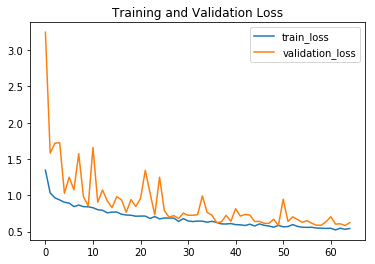

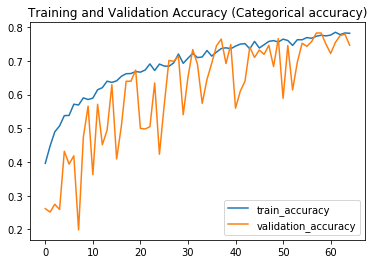

Done training model

Saving model


INFO:root:
 Saved model structure to model file camvid/camvid_image_segmentation_nn_weighted_sgd.json and weights to camvid/camvid_image_segmentation_nn_weighted_sgd.h5


In [3]:
## 3. Train the model here.

from keras.callbacks import EarlyStopping, ModelCheckpoint
import kaggle_data_generator as kdg
import utils
from skimage import io
import cv2
import utils
import matplotlib.pyplot as plt
from scipy import misc
import logging
from logging import Logger
from keras.callbacks import TensorBoard
from time import time
## 3. Model training

logs_path = utils.get_config_value("../image_segmentation.ini", "Camvid", "logFilePath")
print("Log file path is", logs_path)

checkpoints_path = utils.get_config_value("../image_segmentation.ini", "Camvid", "modelCheckpointsPath")
print("Model checkpoints path is ", checkpoints_path)

batch_size = int(utils.get_config_value("../image_segmentation.ini", "Camvid", "BatchSize"))
print("Batch size is ",batch_size)

epochs = int(utils.get_config_value("../image_segmentation.ini", "Camvid", "Epochs"))
print("Epochs is", epochs)

# https://fizzylogic.nl/2017/05/08/monitor-progress-of-your-keras-based-neural-network-using-tensorboard/
tensorboard = TensorBoard(log_dir=logs_path + "/{}".format(time()))

# https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/
callbacks = [EarlyStopping(monitor='val_loss', verbose = 1, patience=15),
             ModelCheckpoint(filepath=checkpoints_path, monitor='val_loss', verbose = 1, save_best_only=True,
                            save_weights_only = True),
            tensorboard]

steps_per_epoch = camvid_data_manager.get_number_of_training_records() // batch_size
validation_steps = camvid_data_manager.get_number_of_validation_records() // batch_size

camvid_data_manager.init_generator(kdg.BatchType.TRAIN_DATA)
camvid_data_manager.init_generator(kdg.BatchType.VALIDATION_DATA)

print("Steps per epoch is ", steps_per_epoch)
print("Validation steps is ", validation_steps)

history = model.fit_generator(
        camvid_data_manager.get_next_batch_train(batch_size), 
        steps_per_epoch = steps_per_epoch, 
        epochs = epochs,
        callbacks = callbacks,
        verbose = 1,
        validation_data = camvid_data_manager.get_next_batch_validate(batch_size),
        validation_steps = validation_steps)

utils.plot_training_graphs(history, "Training and Validation Loss", "loss", "val_loss", "train_loss", "validation_loss")
#utils.plot_training_graphs(history, "Training and Validation Accuracy (Dice coefficients)", "dice_coef", "val_dice_coef", "train_accuracy", "validation_accuracy")
utils.plot_training_graphs(history, "Training and Validation Accuracy (Categorical accuracy)", "categorical_accuracy", 
                           "val_categorical_accuracy", "train_accuracy", "validation_accuracy")

print("Done training model")
print("\nSaving model")
segnet_instance.save()